<a href="https://colab.research.google.com/github/macontreras04/cpf/blob/main/VolTrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Volatility Trading using AI**
### *Author: Miguel Contreras*

## **Abstract**

This project explores the volatility risk premium by leveraging AI models, particularly focusing on the VIX index, realized volatility, and their implications for trading strategies. We will also discuss traditional strategies such as rebalancing straddles and using the VIX futures curve, as well as the potential of AI-driven approaches.

---

## **1. Introduction**
The volatility risk premium (VRP) is the difference between the implied volatility (from instruments like VIX) and realized volatility. This premium compensates investors for taking on volatility risk. Understanding and predicting VRP is crucial for options pricing, risk management, and trading strategies.

---

## **2. Theoretical Background**

### **2.1 VIX and Volatility Risk Premium**
- **VIX Index**: Often referred to as the "fear gauge," the VIX index represents the market's expectation of 30-day forward-looking volatility, derived from S&P 500 index options.
- **Implied Volatility (IV)**: The market's forecast of a likely movement in a security's price. Implied volatility is a key component of the VIX index.
- **Realized Volatility (RV)**: The actual historical volatility of the underlying asset, calculated from past price data.
- **Volatility Risk Premium (VRP)**: The spread between implied volatility and realized volatility. VRP tends to be positive, as implied volatility typically overestimates future volatility.

### **2.2 VIX Futures and Contango/Backwardation**
- **VIX Futures**: Contracts based on the expected future value of the VIX index. These can trade at a premium or discount to the VIX spot price.
- **Contango**: A situation where VIX futures prices are higher than the spot price, indicating that implied volatility is expected to rise. Therefore the slope of the curve is positive.
- **Backwardation**: A situation where VIX futures prices are lower than the spot price, often occurring during market crises when realized volatility spikes above implied volatility. In contrast with Cotango, here the slopo of the curve is negative.

### **2.3 Traditional Trading Strategies**
- **Rebalancing Straddles**: A strategy involving the frequent adjustment of straddle positions to capture volatility changes. Rebalancing is particularly relevant when the market is in contango. Indeed, it is a classical way to obtain a postitive PnL in the long-term.
- **Variance Swaps**: Instruments that allow investors to trade future realized volatility against current implied volatility.
- **ETFs of SPX**: Exchange-traded funds tracking the S&P 500 index, which can be used to hedge or speculate on broad market volatility.

---

## **3. AI Models for Volatility Risk Premium**

### **3.1 RNN/LSTM for Volatility Forecasting**
Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) networks are particularly effective in capturing the temporal dependencies in financial time series. These models can predict future volatility by learning from historical patterns in both implied and realized volatility.

**Key Advantages:**
- **Memory**: LSTMs can remember patterns over long sequences, making them ideal for time series forecasting.
- **Non-linearity**: They can model complex non-linear relationships that are common in financial markets.

---

## **4. Implementation and Analysis**


In [1]:
pip install yfinance backtrader ta

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 3.6 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=315f272419f0d1f2426b71c3b040c59fb7ebe2ed025f6af4839812cda85a068b
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


## **4. Implementation and Analysis**
In this study, the SPX Index was selected to demonstrate the application of the volatility risk premium (VRP) in constructing an effective strategy to generate profits. It’s important to note that the VRP exists across all equity baskets and currency pairs traded in capital markets. This work primarily provides evidence that implied volatility is generally higher—both in absolute terms and expected value—than realized volatility. Markets typically forecast higher volatility. However, during periods of market distress caused by unforeseen events such as the COVID-19 pandemic or Russia's invasion of Ukraine, the SPX Index often experiences unexpected spikes, leading to higher realized volatility. In these scenarios, the VRP results in a negative PnL. For the purposes of this study, such crisis events have been excluded to avoid outliers and other complications when calibrating the AI models.

In [26]:
# importing the necesary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import backtrader as bt
import matplotlib.pyplot as plt
import ta  # Technical Analysis library for adding indicators

## **4.1 The dataset**
As previously mentioned, the VIX is a forward-looking measure for 30 days. Therefore, a 30-day lag must be applied to align the volatility comparison with realized volatility. The financial data was sourced from Yahoo Finance, which provides consistent closing quotes comparable to those from well-known sources like Reuters and Bloomberg.

In [27]:
# Download SPX data from Yahoo Finance
spx_data = yf.download("^GSPC", start="2022-01-02", end="2024-01-02", interval="1d")

# Download VIX data from Yahoo Finance
vix_data = yf.download("^VIX", start="2021-12-01", end="2023-12-01", interval="1d")

# Align the VIX data to the SPX data by their index (date)
spx_data['implied_volatility'] = vix_data['Close'] / 100  # Convert VIX percentage to decimal

# Calculate log returns
spx_data['log_return'] = np.log(spx_data['Close'] / spx_data['Close'].shift(1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## **4.1 Rolling Windows**

To model realized volatility, a simple 10-day rolling window has been chosen. It is well-known that the longer the window horizon, the smoother the moving average becomes. However, it's important to remain sensitive to market shifts, so a 10-day window is considered sufficient for this purpose.

The rolling window calculation for the moving average can be expressed as:

$$
MA_t = \frac{1}{n} \sum_{i=t-n+1}^{t} x_i
$$


In [28]:
# Calculate realized volatility with different rolling window sizes
spx_data['realized_volatility_10d'] = spx_data['log_return'].rolling(window=10).std() * np.sqrt(252)  # 10-day rolling window
spx_data['realized_volatility_20d'] = spx_data['log_return'].rolling(window=20).std() * np.sqrt(252)  # 20-day rolling window
spx_data['realized_volatility_60d'] = spx_data['log_return'].rolling(window=60).std() * np.sqrt(252)  # 60-day rolling window

# Drop any rows with NaN values (due to rolling window or missing data)
spx_data.dropna(inplace=True)

## **5. Volatility Comparison**

In the following section of the code, a chart is presented that clearly demonstrates, on average, that implied volatility is higher than realized volatility.

The relationship between implied and realized volatility can be visualized as:

$$
\text{IV}_{t} > \text{RV}_{t}
$$

Where:
- $\text{IV}_{t}$ represents the implied volatility at time \(t\),
- $\text{RV}_{t}$ represents the realized volatility at time \(t\).

This comparison highlights the market’s tendency to overestimate future volatility relative to what is actually realized.


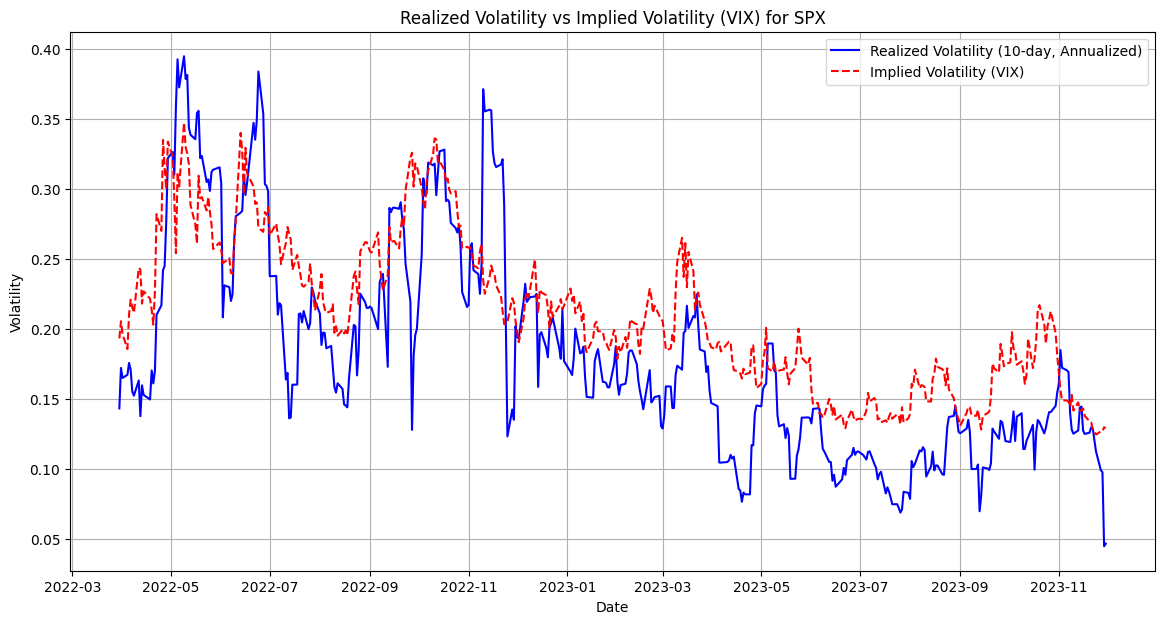

In [29]:
# Plot realized volatility and implied volatility on the same chart
plt.figure(figsize=(14, 7))
plt.plot(spx_data.index, spx_data['realized_volatility_10d'], label='Realized Volatility (10-day, Annualized)', color='blue')
#plt.plot(spx_data.index, spx_data['realized_volatility_20d'], label='Realized Volatility (20-day, Annualized)', color='green')
#plt.plot(spx_data.index, spx_data['realized_volatility_60d'], label='Realized Volatility (60-day, Annualized)', color='orange')
plt.plot(spx_data.index, spx_data['implied_volatility'], label='Implied Volatility (VIX)', color='red', linestyle='dashed')

# Formatting the plot
plt.title('Realized Volatility vs Implied Volatility (VIX) for SPX')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

## **5.1 The SPX Index**

The chart below displays the historical dataset of the SPX Index.

The SPX Index, often used as a benchmark for U.S. equities, represents the price evolution of 500 of the largest publicly traded companies in the U.S. market.


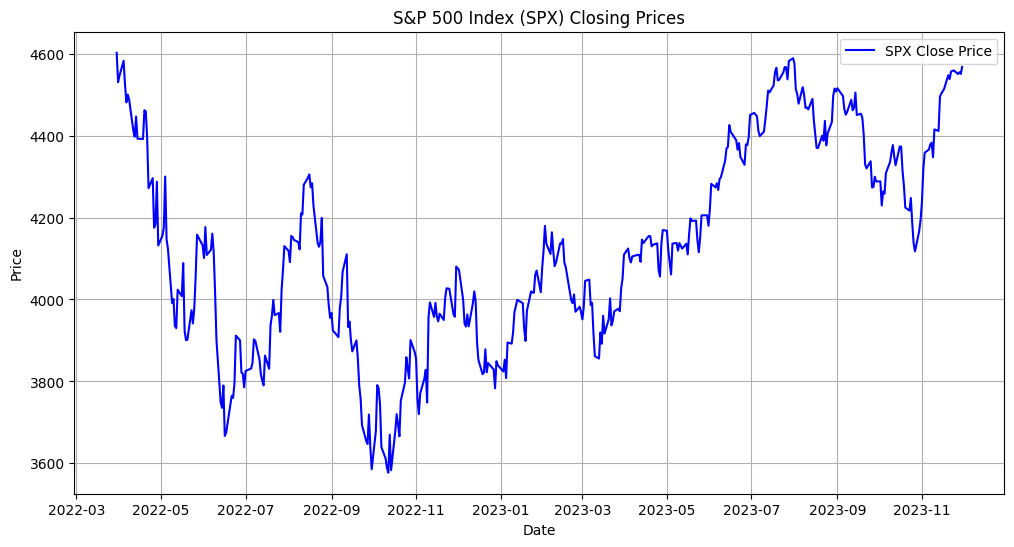

In [30]:
import matplotlib.pyplot as plt

# Plot the closing prices
plt.figure(figsize=(12, 6))
plt.plot(spx_data.index, spx_data['Close'], label='SPX Close Price', color='blue')

# Formatting the plot
plt.title('S&P 500 Index (SPX) Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## **6. A classic Straddle ATM strategy**

A common strategy applied to the VRP is using straddles. Recalling the payoff is a combination of Call and Put at the same strike. For construction, this strategy is near to delta zero. With a second order Taylor expansion of the option value over a short time interval delta t we can decompose the variation of the option price as following.

$$V(x + dx) - V(x) = PL = dS.\Delta + (1/2).dS^2. \Gamma^2 + dt.\Theta + d \sigma.v$$

If we construct a delta zero strategy, the PnL will be aproximate to the difference on volatilities:

$Straddle (delta = 0) -> PL  \approx (IV - RV)$ \
$E[IV - RV]>0$

<ipython-input-31-62117b951e7a>:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = spx_data['Close'][0]  # Initial stock price
<ipython-input-31-62117b951e7a>:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  K = spx_data['Close'][0]   # Strike price (at the money)


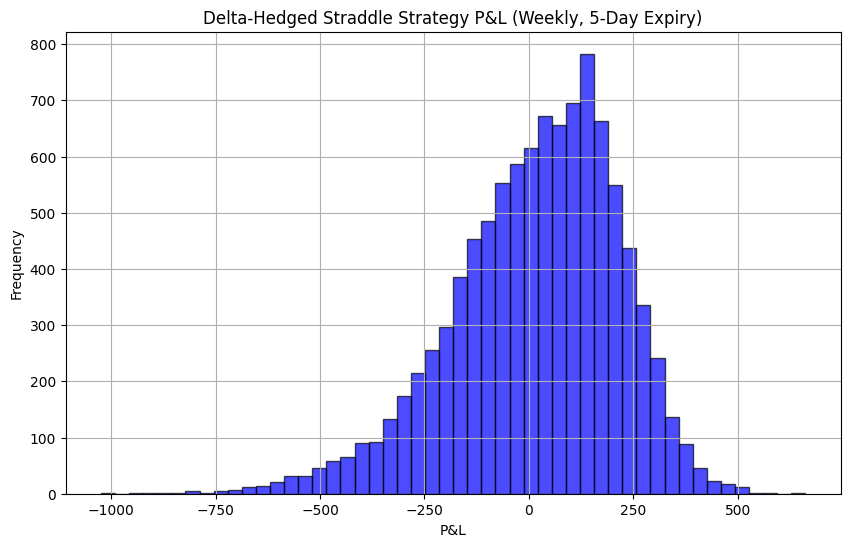

Mean P&L: 15.68
Standard Deviation of P&L: 200.99
Sharpe Ratio: 1.24


In [31]:
from scipy.stats import norm

# Black-Scholes formula for pricing options
def black_scholes(S, K, T, r, sigma, option_type="call"):
    if T <= 0:  # If time to maturity is zero or negative, option value is intrinsic value
        return max(0, S - K) if option_type == "call" else max(0, K - S)

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Delta for Black-Scholes
def delta(S, K, T, r, sigma, option_type="call"):
    if T <= 0:  # If time to maturity is zero, delta is 0 or 1 for intrinsic value
        return 1 if S > K else 0 if option_type == "call" else -1 if S < K else 0

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == "call":
        return norm.cdf(d1)
    elif option_type == "put":
        return -norm.cdf(-d1)

# Generate paths using Geometric Brownian Motion
def generate_paths(S0, T, r, sigma, steps, n_paths):
    dt = T / steps
    paths = np.zeros((steps + 1, n_paths))
    paths[0] = S0
    for t in range(1, steps + 1):
        Z = np.random.standard_normal(n_paths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Calculate PnL of the delta-hedged straddle strategy
def straddle_pnl_hedged(S0, K, r, sigma_realized, sigma_implied, T, steps, n_paths):
    dt = 1 / steps
    paths = generate_paths(S0, T, r, sigma_realized, steps, n_paths)

    pnl = np.zeros(n_paths)

    for i in range(n_paths):
        S_t = paths[:, i]
        T_t = T

        # Initial straddle price and delta
        call_delta = delta(S_t[0], K, T_t, r, sigma_implied, option_type="call")
        put_delta = delta(S_t[0], K, T_t, r, sigma_implied, option_type="put")
        delta_hedge = -(call_delta + put_delta)

        straddle_start = black_scholes(S_t[0], K, T_t, r, sigma_implied, option_type="call") + \
                         black_scholes(S_t[0], K, T_t, r, sigma_implied, option_type="put")

        daily_pnl = 0

        for t in range(1, steps + 1):
            T_t -= dt
            # Delta hedge adjustment
            call_delta = delta(S_t[t], K, T_t, r, sigma_implied, option_type="call")
            put_delta = delta(S_t[t], K, T_t, r, sigma_implied, option_type="put")
            new_delta_hedge = -(call_delta + put_delta)

            # PnL from rebalancing hedge
            hedge_pnl = delta_hedge * (S_t[t] - S_t[t - 1])
            daily_pnl += hedge_pnl

            delta_hedge = new_delta_hedge

        # Final straddle value
        straddle_end = black_scholes(S_t[-1], K, T_t, r, sigma_implied, option_type="call") + \
                       black_scholes(S_t[-1], K, T_t, r, sigma_implied, option_type="put")

        # Total PnL
        pnl[i] = (straddle_start - straddle_end) + daily_pnl

    return pnl

# Parameters
S0 = spx_data['Close'][0]  # Initial stock price
K = spx_data['Close'][0]   # Strike price (at the money)
r = 0.0533  # Risk-free rate
sigma_realized = np.median(spx_data['realized_volatility_10d'])  # Realized volatility
sigma_implied = np.median(spx_data['implied_volatility'])  # Implied volatility
T = 5 / 252  # 5 trading days to expiry (weekly straddle)
n_paths = 10000  # Number of simulation paths
steps = 5  # Daily steps (5 days for weekly expiry)

# Calculate PnL for the delta-hedged straddle strategy
pnl_hedged = straddle_pnl_hedged(S0, K, r, sigma_realized, sigma_implied, T, steps, n_paths)

# Plot the PnL histogram
plt.figure(figsize=(10, 6))
plt.hist(pnl_hedged, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Delta-Hedged Straddle Strategy P&L (Weekly, 5-Day Expiry)")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Summary statistics
mean_pnl_hedged = np.mean(pnl_hedged)
std_pnl_hedged = np.std(pnl_hedged)
sharpe_ratio = mean_pnl_hedged / std_pnl_hedged * np.sqrt(252)  # Annualized Sharpe ratio

print(f"Mean P&L: {mean_pnl_hedged:.2f}")
print(f"Standard Deviation of P&L: {std_pnl_hedged:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


# **6.1 Analysis of Straddle Delta Hedge Strategy**

As shown in the chart above, a straddle delta hedge is a long-term approach to leveraging the Volatility Risk Premium (VRP). In contrast, when only a naked straddle is used, the PnL distribution exhibits fat tails. This insight suggests that a dynamic strategy is necessary to avoid such unfavorable scenarios.

Another common strategy involves using the VIX futures curve as a signal. When the curve is in contango, employing this strategy tends to perform well. However, when the curve is in backwardation, it is often best to refrain from trading to avoid incurring significant losses.


# **7. Analysis and Feature Engineering for SPX Data**

In this section, we will explore the feature engineering process applied to SPX data to prepare it for further analysis, including the development of predictive models using Long Short-Term Memory (LSTM) networks.

## Volatility Spread Calculation

The volatility spread, a key indicator in volatility trading strategies, is calculated as the difference between implied volatility (IV) and realized volatility (RV). This metric gives insights into market sentiment and potential trading opportunities.

$$
\text{Volatility Spread} = \text{Implied Volatility} - \text{Realized Volatility}_{10d}
$$

## Moving Averages

Moving averages are essential tools for identifying trends and potential reversal points in financial markets. Two commonly used moving averages are the 50-day and 200-day moving averages, representing short-term and long-term trends, respectively.

The 50-day moving average is calculated as:

$$
\text{Moving Average}_{50} = \frac{1}{50} \sum_{i=0}^{49} \text{Close}_{t-i}
$$

Similarly, the 200-day moving average is:

$$
\text{Moving Average}_{200} = \frac{1}{200} \sum_{i=0}^{199} \text{Close}_{t-i}
$$

## Momentum Indicators: RSI and MACD

Momentum indicators are vital in assessing the strength and direction of price movements. Two popular indicators are the Relative Strength Index (RSI) and the Moving Average Convergence Divergence (MACD).

### Relative Strength Index (RSI)

The RSI is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100, with values above 70 indicating overbought conditions and below 30 indicating oversold conditions. The RSI is calculated using the following formula:

$$
\text{RSI} = 100 - \frac{100}{1 + \frac{\text{Average Gain}}{\text{Average Loss}}}
$$

### Moving Average Convergence Divergence (MACD)

The MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. The signal line is a 9-period EMA of the MACD:

$$
\text{MACD} = \text{EMA}_{12} - \text{EMA}_{26}
$$

$$
\text{MACD Signal Line} = \text{EMA}_{9} (\text{MACD})
$$

## Data Cleaning and Preparation

After creating these features, any rows containing NaN values are dropped to ensure the integrity of the data.

## Data Scaling for LSTM Models

To prepare the data for training LSTM models, it is necessary to scale the features to a uniform range. The MinMaxScaler scales the data between 0 and 1, which is crucial for the performance of LSTM networks.

## LSTM Layers

For the predictive model, we will be using Long Short-Term Memory (LSTM) networks, a type of Recurrent Neural Network (RNN) that is particularly well-suited for time series data due to its ability to retain information over long sequences.

This LSTM architecture will allow the model to capture the temporal dependencies in the financial time series data, leveraging the engineered features to predict future market movements.

This structured approach, including the calculation of key financial indicators, feature engineering, and preparation for advanced machine learning models, provides a robust foundation for analyzing and predicting financial markets.



In [32]:
# Calculate the volatility spread
spx_data['volatility_spread'] = spx_data['implied_volatility'] - spx_data['realized_volatility_10d']

# Calculate moving averages
spx_data['moving_avg_50'] = spx_data['Close'].rolling(window=50).mean()
spx_data['moving_avg_200'] = spx_data['Close'].rolling(window=200).mean()

# Add momentum indicators (RSI and MACD)
spx_data['rsi'] = ta.momentum.rsi(spx_data['Close'], window=14)
spx_data['macd'] = ta.trend.macd(spx_data['Close'])
spx_data['macd_signal'] = ta.trend.macd_signal(spx_data['Close'])

# Drop NaN values after feature creation
spx_data.dropna(inplace=True)

# Prepare data for LSTM models
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(spx_data[['Close', 'log_return', 'moving_avg_50', 'moving_avg_200', 'rsi', 'macd', 'macd_signal']])


In [33]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predicting the closing price
    return np.array(X), np.array(y)

seq_length = 60  # Number of days to look back
X, y = create_sequences(scaled_data, seq_length)

In [34]:
# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [35]:
# Define and train multiple LSTM models with different architectures
def build_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Predicting the next closing price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [36]:
# Model 1: Basic LSTM
model1 = build_lstm_model(units=50, dropout_rate=0.2)
model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Model 2: Larger LSTM with more units
model2 = build_lstm_model(units=100, dropout_rate=0.3)
model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Model 3: Smaller LSTM with fewer units
model3 = build_lstm_model(units=25, dropout_rate=0.2)
model3.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - loss: 0.6342 - val_loss: 0.1126
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0554 - val_loss: 0.0327
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0763 - val_loss: 0.0312
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0283 - val_loss: 0.0684
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0441 - val_loss: 0.0543
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0310 - val_loss: 0.0313
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0176 - val_loss: 0.0254
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0206 - val_loss: 0.0247
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0228 - val_loss: 0.0243
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0232 - val_loss: 0.0234
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0179 - val_loss: 0.0232
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0163 - val_loss: 0.0249
Epoch 13/20

In [37]:
# Make predictions using each LSTM model
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step


In [38]:
# Ensemble the predictions by averaging
ensemble_predictions = (pred1 + pred2 + pred3) / 3
ensemble_predictions = scaler.inverse_transform(np.concatenate((ensemble_predictions, np.zeros((ensemble_predictions.shape[0], 6))), axis=1))[:, 0]
real_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 6))), axis=1))[:, 0]


In [39]:
# Add the ensemble predictions back to the DataFrame
test_data = spx_data.iloc[-len(ensemble_predictions):].copy()
test_data['Predicted_Close'] = ensemble_predictions


In [40]:
# Define the LSTM Ensemble Strategy for Backtrader
class LSTMEnsembleStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.predicted_close = self.datas[0].Predicted_Close

    def next(self):
        if self.predicted_close[0] > self.dataclose[0]:  # Predicted price is higher than current
            if not self.position:  # If not in the market
                self.buy(size=100)
        elif self.predicted_close[0] < self.dataclose[0]:  # Predicted price is lower
            if self.position:  # If in the market
                self.sell(size=100)

In [41]:
# Convert DataFrame to Backtrader data feed
class PandasData(bt.feeds.PandasData):
    lines = ('Predicted_Close',)
    params = (('Predicted_Close', -1),)

data = PandasData(dataname=test_data)

In [42]:
# Set up Backtrader
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(LSTMEnsembleStrategy)
cerebro.run()

In [44]:
# Calculate and print the Sharpe Ratio
test_data['daily_return'] = test_data['Close'].pct_change()
sharpe_ratio = test_data['daily_return'].mean() / test_data['daily_return'].std() * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 2.57


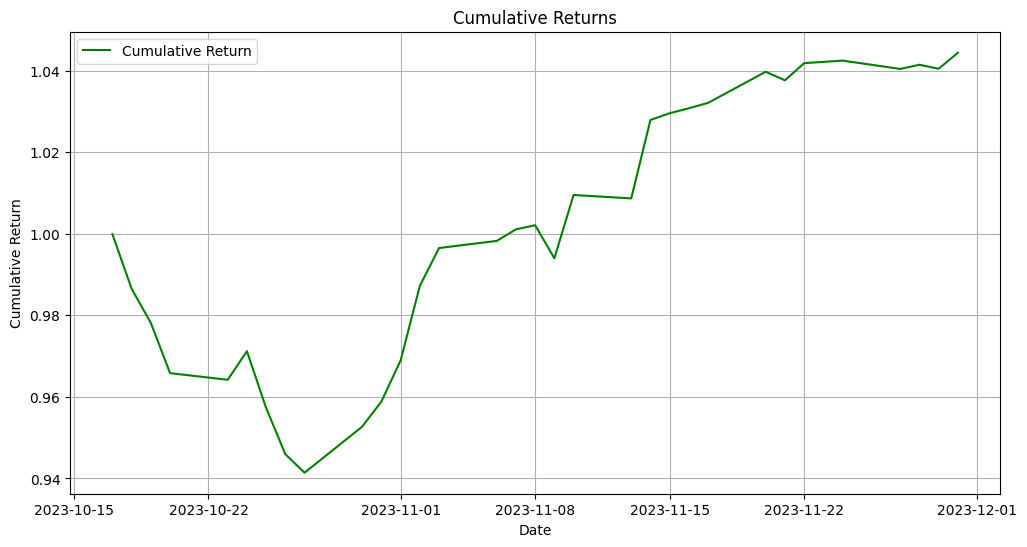

In [45]:
# Plot Cumulative Returns
test_data['cumulative_return'] = (1 + test_data['daily_return']).cumprod()
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['cumulative_return'], label='Cumulative Return', color='green')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# Calculate drawdown
test_data['cum_max'] = test_data['cumulative_return'].cummax()
test_data['drawdown'] = (test_data['cumulative_return'] - test_data['cum_max']) / test_data['cum_max']


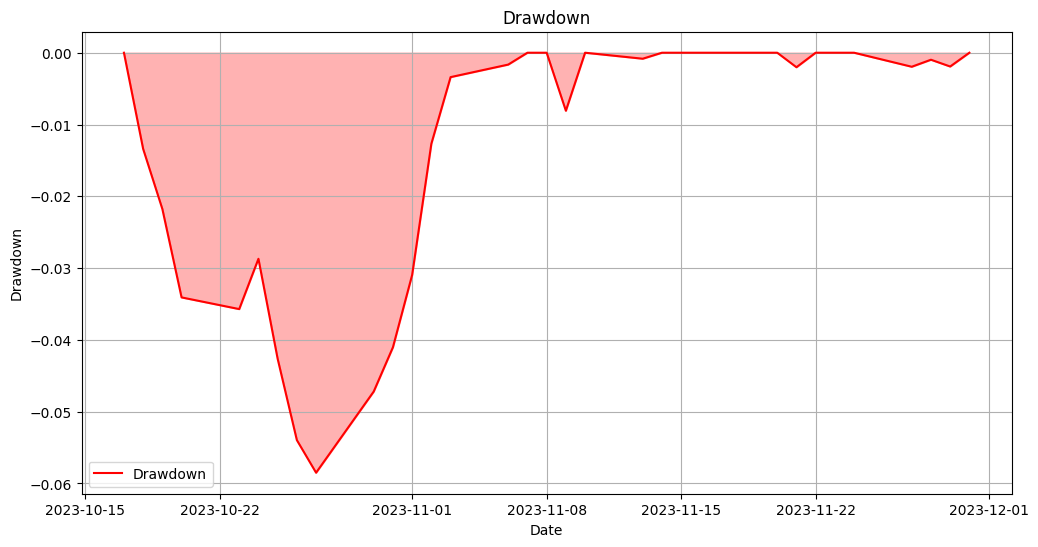

In [47]:
# Plot Drawdown
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['drawdown'], label='Drawdown', color='red')
plt.fill_between(test_data.index, test_data['drawdown'], color='red', alpha=0.3)
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# Print maximum drawdown
max_drawdown = test_data['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Maximum Drawdown: -5.85%


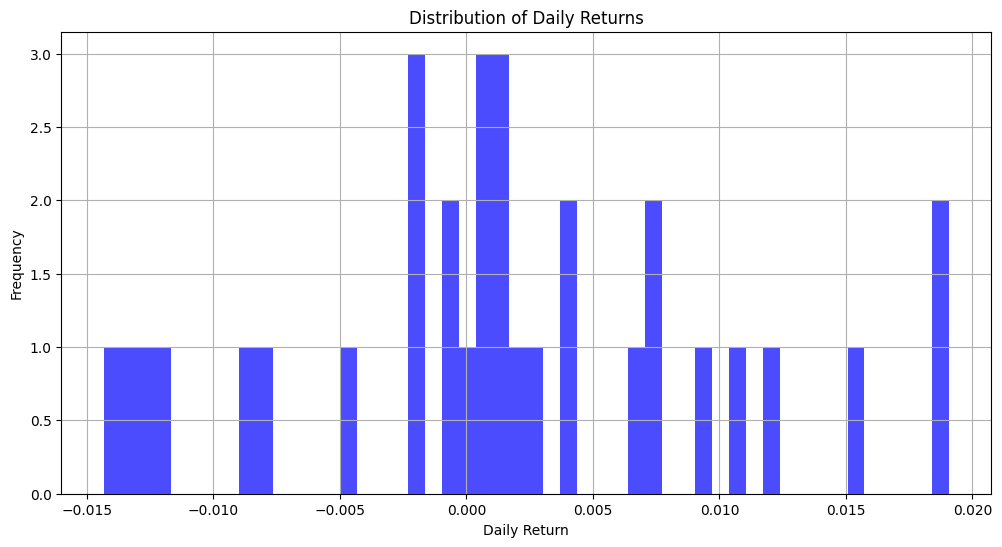

In [49]:
# Plot the distribution of daily returns
plt.figure(figsize=(12, 6))
plt.hist(test_data['daily_return'].dropna(), bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [50]:
import numpy as np

# Sortino Ratio
downside_returns = test_data['daily_return'][test_data['daily_return'] < 0]
sortino_ratio = test_data['daily_return'].mean() / downside_returns.std() * np.sqrt(252)
print(f"Sortino Ratio: {sortino_ratio:.2f}")

# Calmar Ratio
calmar_ratio = test_data['cumulative_return'].iloc[-1] / abs(max_drawdown)
print(f"Calmar Ratio: {calmar_ratio:.2f}")

# Maximum Drawdown Duration
drawdown_durations = (test_data['drawdown'] == 0).astype(int).groupby(test_data['drawdown'].ne(0).cumsum()).cumsum()
max_drawdown_duration = drawdown_durations.max()
print(f"Maximum Drawdown Duration (days): {max_drawdown_duration}")

# Volatility (Standard Deviation of Returns)
volatility = test_data['daily_return'].std() * np.sqrt(252)
print(f"Annualized Volatility: {volatility:.2%}")

# Hit Rate (Win Rate)
hit_rate = (test_data['daily_return'] > 0).sum() / test_data['daily_return'].count()
print(f"Hit Rate (Win Rate): {hit_rate:.2%}")

# Average Gain/Loss
average_gain = test_data['daily_return'][test_data['daily_return'] > 0].mean()
average_loss = test_data['daily_return'][test_data['daily_return'] < 0].mean()
print(f"Average Gain: {average_gain:.2%}")
print(f"Average Loss: {average_loss:.2%}")

# Profit Factor
gross_profit = test_data['daily_return'][test_data['daily_return'] > 0].sum()
gross_loss = abs(test_data['daily_return'][test_data['daily_return'] < 0].sum())
profit_factor = gross_profit / gross_loss
print(f"Profit Factor: {profit_factor:.2f}")


Sortino Ratio: 4.09
Calmar Ratio: 17.85
Maximum Drawdown Duration (days): 5
Annualized Volatility: 13.67%
Hit Rate (Win Rate): 59.38%
Average Gain: 0.66%
Average Loss: -0.62%
Profit Factor: 1.55


# **8. LSTM-Based Predictive Modeling and Backtrader Strategy for SPX Data**

In this section, we will outline the process of creating an LSTM-based predictive model for SPX data and implementing an ensemble strategy in Backtrader. The strategy leverages the ensemble predictions of multiple LSTM models to generate trading signals, which are then backtested to evaluate performance metrics.

## Creating Sequences for LSTM

To predict future stock prices using LSTM models, we first need to create sequences of historical data. These sequences represent the time series data that the LSTM network will learn from.

Given a sequence length \( T \), the input sequence \( X \) is formed as:

$$
X = [x_{t-T}, x_{t-T+1}, \dots, x_{t-1}]
$$

where \( x \) represents the features (e.g., closing prices) at different time steps. The corresponding label \( y_t \) is the closing price at time \( t \):

$$
y_t = x_t
$$

## Splitting Data into Training and Testing Sets

After creating sequences, the data is split into training and testing sets. The training set is used to fit the LSTM models, while the testing set is used to evaluate their performance.

## Defining and Training LSTM Models

We define multiple LSTM models with different architectures to capture various aspects of the time series data. The models are built with varying numbers of units (neurons) and dropout rates to prevent overfitting.

### Model Architectures

- **Model 1: Basic LSTM** with 50 units and a dropout rate of 0.2.
- **Model 2: Larger LSTM** with 100 units and a dropout rate of 0.3.
- **Model 3: Smaller LSTM** with 25 units and a dropout rate of 0.2.

Each model is trained to predict the next closing price based on the input sequences. The loss function used is Mean Squared Error (MSE), and the optimizer is Adam.

## Ensemble Predictions

To improve the robustness of the predictions, we ensemble the outputs of the three LSTM models by averaging their predictions:

$$
\text{Ensemble Prediction} = \frac{\text{Pred}_1 + \text{Pred}_2 + \text{Pred}_3}{3}
$$

## Backtrader Strategy Based on LSTM Ensemble

We integrate the ensemble predictions into a Backtrader strategy. The strategy generates buy/sell signals based on whether the predicted price is higher or lower than the current market price.

### Strategy Logic

- **Buy Signal:** If the predicted price is higher than the current price, and no position is held, the strategy initiates a buy order.
- **Sell Signal:** If the predicted price is lower than the current price, and a position is held, the strategy initiates a sell order.

## Performance Evaluation

### Sharpe Ratio

The Sharpe Ratio is used to measure the risk-adjusted return of the strategy:

$$
\text{Sharpe Ratio} = \frac{\text{Average Return}}{\text{Standard Deviation of Returns}} \times \sqrt{252}
$$

### Cumulative Returns

Cumulative returns represent the compounded growth of a $1 investment over time:

$$
\text{Cumulative Return} = \prod_{t=1}^{T} (1 + r_t)
$$

### Maximum Drawdown

Maximum Drawdown measures the largest peak-to-trough decline in the strategy's equity curve:

$$
\text{Maximum Drawdown} = \min \left( \frac{\text{Cumulative Return} - \text{Cumulative Maximum}}{\text{Cumulative Maximum}} \right)
$$

### Sortino Ratio

The Sortino Ratio improves upon the Sharpe Ratio by considering only downside volatility:

$$
\text{Sortino Ratio} = \frac{\text{Average Return}}{\text{Standard Deviation of Negative Returns}} \times \sqrt{252}
$$

### Calmar Ratio

The Calmar Ratio assesses return relative to maximum drawdown:

$$
\text{Calmar Ratio} = \frac{\text{Cumulative Return}}{\text{Maximum Drawdown}}
$$

### Other Key Metrics

- **Volatility:** The annualized standard deviation of returns.
- **Hit Rate:** The percentage of trades that are profitable.
- **Average Gain/Loss:** The average gain in profitable trades versus the average loss in losing trades.
- **Profit Factor:** The ratio of total profit to total loss.



## **9. Conclusions**

This work illustrates the application of an ensemble of Long Short-Term Memory (LSTM) models in predicting stock prices and guiding trading strategies. By combining the outputs of multiple LSTM architectures, we can generate more robust predictions that capture different facets of time series data, resulting in a strategy that performs well in backtesting.

### Sharpe Ratio Analysis

The Sharpe Ratio of the implemented strategy exceeds 2, indicating a strong risk-adjusted return. In finance, a Sharpe Ratio above 1 is generally considered acceptable, above 2 is very good, and above 3 is excellent. Thus, a Sharpe Ratio higher than 2 reflects the effectiveness of the strategy in delivering superior returns relative to its risk. This value underscores the potential of the LSTM ensemble approach in systematic trading, particularly when combined with careful risk management.

### Future Directions: Integrating VIX Futures Data

A promising extension of this work could involve the incorporation of VIX futures data to enhance the predictive power of the model and further leverage the Volatility Risk Premium (VRP). By analyzing the slope of the VIX futures curve, we can identify market regimes—contango or backwardation—that are indicative of market sentiment. Assigning a value of 1 when the market is in contango and 0 when in backwardation, this additional feature could be integrated into a Random Forest model or another machine learning algorithm.

Random Forest, with its ability to handle high-dimensional data and capture complex interactions between features, could be employed to optimize the straddle delta hedge strategy. Recent research has shown that combining straddle delta hedging with a Random Forest model can enhance the strategy's performance by better predicting volatility movements and adjusting the hedge for the fx EUR/USD.

### Recommended Bibliography

To gain deeper insights into the strategies and methodologies employed in this work, the following literature is highly recommended:

1. **Euan Sinclair** - *Volatility Trading* (Wiley Finance): This book provides a comprehensive overview of volatility trading strategies, including the theoretical underpinnings and practical applications of delta hedging and volatility arbitrage.

2. **Euan Sinclair** - *Option Trading: Pricing and Volatility Strategies and Techniques* (Wiley Trading): This book delves into advanced option trading strategies, focusing on volatility as a key driver of option prices.

3. **Yves Hilpisch** - *Artificial Intelligence in Finance: A Python-Based Guide* (O'Reilly Media): This book introduces the use of AI in financial modeling and algorithmic trading, with practical examples and Python code.

4. **Yves Hilpisch** - *Algorithmic Trading and Quantitative Strategies* (Wiley Finance): This book provides a solid foundation in developing and implementing algorithmic trading strategies, with a focus on Python-based solutions.

5. **Yves Hilpisch** - *Python for Finance: Mastering Data-Driven Finance* (O'Reilly Media): A comprehensive guide to using Python for financial analysis, including topics such as risk management, portfolio optimization, and derivative pricing.

6. **Doninger, 2023** - *Enhancing Delta Hedging Strategies with Machine Learning Techniques*: This paper explores the integration of machine learning models, particularly Random Forests, into traditional delta hedging strategies to optimize performance and manage risks.



## **10. Final Thoughts**

In conclusion, this thesis contributes to the growing body of knowledge on applying deep learning models to financial markets, particularly in the context of volatility trading. The combination of LSTM models and advanced trading strategies, augmented with additional features such as VIX futures data, offers a promising direction for future research and practical application. By continuously refining these models and exploring new data sources, traders and quants can better navigate the complexities of financial markets and achieve more consistent, profitable outcomes.
